# Primerjava pristopov za luščenje ključnih besed na povzetkih člankov s ključno besedo "Longevity" - not lemmatized

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz nabora povzetkov člankov s ključno besedo "Longevity" v zbirki PubMed.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede s ključnimi besedami, ki so jih označili avtorji člankov. Za vsako metodo bomo prikazali povprečno preciznost (precision), priklic (recall) in mero F1.

In [3]:
import string
import ast

import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import yake
import rake
from operator import is_not
from functools import partial

from textsemantics import specific_words
from utils.scores import (
    precision, recall, average_precision, average_recall, average_f_score,
    take_n, score_in_len_range
)

# max len of keyphrase
N_GRAM_LEN = 3

Naložimo metapodatke in dokumente iz zbirke in dokumente preprocesiramo in izluščimo posamezne besede.

In [24]:
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus, remove_stopwords=False):
    tokenizer = RegexpTokenizer("\w+")
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        if remove_stopwords:
            tokens = [token for token in tokens if token not in stop_words and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

df = pd.read_pickle("data/pubmed_longevity.pkl")
len_before = len(df)

# izpusti članke brez ključnih besed - izbriši None vrednosti v senznamu ključnih besed
# po brisanju None vrednosti nekatera besedila izgubijo ključne besede, odstrani jih
df = df[~df["keywords"].isnull()]
df["keywords"] = df["keywords"].apply(lambda x: [k for k in x if k is not None])
# izputsti kljucne besede z vec kot N_GRAM_LEN besedami
# e.g. if N_GRAM_LEN == 3 we skip just 2% words
df["keywords"] = df["keywords"].apply(lambda x: [k for k in x if len(k.split()) <= N_GRAM_LEN])
df = df[df["keywords"].apply(len) != 0]

# some keywords were not splited on seperate keyword by PubMed so keyword is comma separaed string
# of keywords, others have koma which is part of the keyword. It is hard to distinguish both
# so we are dropping 92 
print("Z vejicami", len(df))
df = df[~df["keywords"].apply(lambda x: any(", " in k for k in x))]
print("Brez vejic", len(df))

# izpusti prazne abstracte
df = df[df["abstract"].str.len() >= 100]

tokens_list = preprocess(df["abstract"])
tokens_list_wo_stopwords = preprocess(df["abstract"], remove_stopwords=True)

print(f"Število dokumentov: {len(df)}/{len_before}")

Z vejicami 4582
Brez vejic 4509
Število dokumentov: 4508/16791


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [5]:
df.head()

,title,abstract,journal,authors,mesh_terms,keywords,pubmed_id,year
0,The practice of self-preserving behavior of th...,One of world trends in health care social poli...,"Problemy sotsial'noi gigieny, zdravookhranenii...","[T K Rostovskaya, A K Ivanova, E A Kniazkova]","[Delivery of Health Care, Demography, Health P...","[demographic behavior, health, longevity, self...",33591658,2021
2,Consumption of field-realistic doses of a wide...,Commercial beekeepers in many locations are ex...,"Environmental pollution (Barking, Essex : 1987)","[Jordan R Glass, Adrian Fisher, Jennifer H Few...","[Animals, Bees, Digestion, Fungicides, Industr...","[Flight metabolic rate, Flight performance, Fu...",33529906,2021
7,Casein-maltodextrin Maillard conjugates encaps...,Practical application of proanthocyanidins (PA...,Food chemistry,"[Xianbao Sun, Xuejiao Wu, Xiangyu Chen, Rui Gu...","[Animals, Antioxidants, Caenorhabditis elegans...","[Antioxidant activity, Bioaccessibility, Casei...",33421900,2020
8,Aging and Senescence across Reproductive Trait...,AbstractWhy do senescence rates of fitness-rel...,The American naturalist,"[Eve B Cooper, Timothée Bonnet, Helen L Osmond...","[Aging, Animals, Australian Capital Territory,...","[Malurus, aging, extrapair paternity, life-his...",33417527,2020
10,Lead stress affects the reproduction of Spodop...,Lead (Pb) stress affects hormone-mediated resp...,Ecotoxicology and environmental safety,"[Jialiang Zhou, Jin Chen, Yinghua Shu]","[Animals, Diet, Environmental Pollutants, Fema...","[Heavy metal stress, Insect reproduction, Mult...",33396104,2020


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metoda z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [27]:
%%time 
def tfidf_method(tokens):
    joined_texts = [" ".join(tokens) for tokens in tokens]
    vectorizer = TfidfVectorizer(ngram_range=(1, N_GRAM_LEN))
    X = vectorizer.fit_transform(joined_texts)
    words = vectorizer.get_feature_names()

    keywords = []
    for row in X:
        features = [(words[i], row[0, i]) for i in row.nonzero()[1]]
        keywords.append(sorted(features, key=lambda tup: tup[1], reverse=True))
    return keywords


tfidf_keywords = tfidf_method(tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

tfidf_keywords_wo_stw = tfidf_method(tokens_list_wo_stopwords)
tfidf_keywords_wo_stw = [[x for x, _ in wds] for wds in tfidf_keywords_wo_stw]

CPU times: user 1min 44s, sys: 2.01 s, total: 1min 46s
Wall time: 2min


In [22]:
%%time 
stop_path = "utils/english-stopwords.txt"
rake_object = rake.Rake(stop_path, max_words_length=3)
def rake_method(text):    
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [x for x, _ in kw if x not in stop_words]

rake_keywords = [rake_method(txt) for txt in df["abstract"]]

CPU times: user 9.92 s, sys: 128 ms, total: 10 s
Wall time: 11.7 s


In [9]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="en", n=3, top=20)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [x for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 8min 37s, sys: 4.67 s, total: 8min 41s
Wall time: 9min 53s


In [10]:
%%time
import spacy
import pytextrank

def text_rank(texts):
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("textrank")
    
    def text_rank(text):
        doc = nlp(text)
        return [x.text for x in doc._.phrases if len(x.text.split()) <= N_GRAM_LEN]

    return [text_rank(t) for t in texts]

text_rank_keywords = text_rank(df["abstract"])

CPU times: user 2min 54s, sys: 15.7 s, total: 3min 10s
Wall time: 3min 29s


In [30]:
methods = [
#     ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("TFIDF - no stopwords", tfidf_keywords_wo_stw),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [31]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

TFIDF - Povprečno število besed: 486.6 Minimalno število specifičnih besed: 47
TFIDF - no stopwords - Povprečno število besed: 327.0 Minimalno število specifičnih besed: 33
RAKE - Povprečno število besed: 59.8 Minimalno število specifičnih besed: 4
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 20
TextRank - Povprečno število besed: 50.4 Minimalno število specifičnih besed: 5


Izračunajmo natančnosti s pripravljenimi merami in jih izrišimo. Izračunamo povprečno preciznost, priklic in mero F1 za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo vse tri mere za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo po en graf za vsako od mer - graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. Četrti graf prikazuje preciznost in priklic na enem grafu. V tem grafu ima metoda krivuljo iz večih točk. Vsaka od točk predstavlja preciznost in priklic za različno število izbranih ključnih besede. Metoda katere krivulja je bližje zgornjemu desnemu kotu, je boljša. 


In [32]:
kw = df['keywords'].tolist()

assert len(kw) == len(df)

precisions = [score_in_len_range(pred, kw, average_precision) for _, pred in methods]
recalls = [score_in_len_range(pred, kw, average_recall)  for _, pred in methods]
f_scores = [score_in_len_range(pred, kw, average_f_score)  for _, pred in methods]

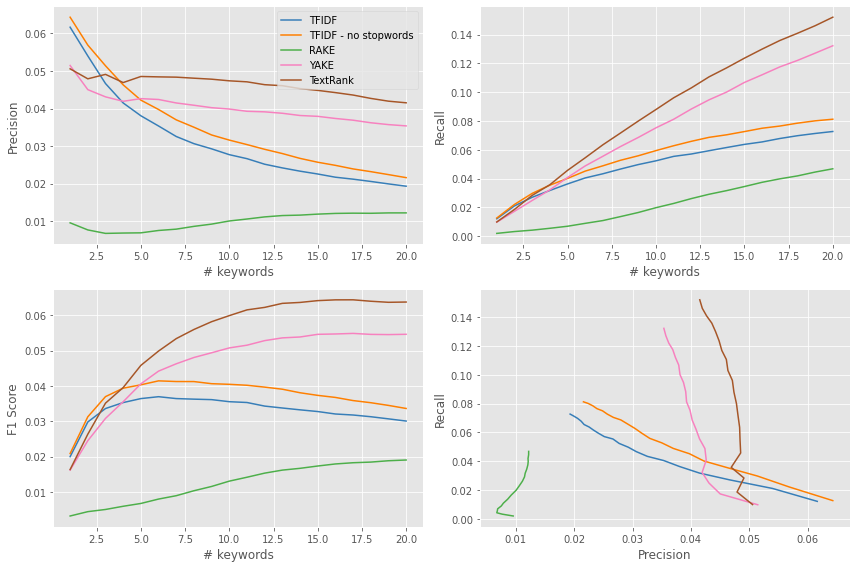

In [33]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

plt.style.use('ggplot')
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Precision", precisions),
    ("Recall", recalls),
    ("F1 Score", f_scores),
)
for i, (title, sc) in enumerate(scores):
    plt.subplot(2, 2, i + 1)
    for p, (l, _), c in zip(sc, methods, CB_color_cycle):
        plt.plot(range(1, 21), p, label=l, color=c)
    if i == 0:
        plt.legend()
    plt.xlabel("# keywords")
    plt.ylabel(title)
        
plt.subplot(2, 2, 4)
for p, r, (l, _), c in zip(precisions, recalls, methods, CB_color_cycle):
    plt.plot(p, r, label=l, color=c)
plt.xlabel("Precision")
plt.ylabel("Recall")

plt.tight_layout()